# Exp 2-18 analysis summary.

Which parameters did best on the tasks?

See `./informercial/Makefile` for experimental
details.

In [6]:
import os
import numpy as np

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from infomercial.exp import meta_bandit
from infomercial.local_gym import bandit
from infomercial.exp.meta_bandit import load_checkpoint
import gym

In [7]:
# ls ../data/exp2*

# Load and process data

In [88]:
data_path ="/Users/qualia/Code/infomercial/data/"
exp_names = ["exp2",
             "exp3",
             "exp4",
             "exp5",
             "exp6",
             "exp7",
             "exp8",
             "exp9",
             "exp10",
             "exp11",
             "exp12",
             "exp13",
             "exp14",
             "exp15",
             "exp16",
             "exp17",             
             "exp18"]
exp_index = list(range(2, 19))

num_exps = 50
num_episodes = 10000
env_names = [
    "BanditOneHigh2-v0",
    "BanditOneHigh10-v0",
    "BanditOneHigh121-v0",
    "BanditOneHigh1000-v0",
    "BanditHardAndSparse2-v0",
    "BanditHardAndSparse10-v0",
    "BanditHardAndSparse121-v0", 
    "BanditHardAndSparse1000-v0"
]

last_trials = -500

In [89]:
exp_index

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [90]:
# For each exp, then each task, extract the p_best, and the last_trials.

# Init final result
p_best = {}
for env in env_names:
        p_best[env] = np.zeros(len(exp_names))
        
for j, exp_name in enumerate(exp_names):
    # Gather traces by bandit: scores, 
    # Qs in a big numpy array (n_exp, n_episodes)
    scores_E = {}
    scores_R = {}
    values_E = {}
    values_R = {}
    controlling = {}
    actions = {}
    best = {}

    # Preallocate the arrays for this env
    for env in env_names:
        scores_E[env] = np.zeros((num_episodes, num_exps))
        scores_R[env] = np.zeros((num_episodes, num_exps))
        values_E[env] = np.zeros((num_episodes, num_exps))
        values_R[env] = np.zeros((num_episodes, num_exps))
        controlling[env] = np.zeros((num_episodes, num_exps))
        actions[env] = np.zeros((num_episodes, num_exps))
        best[env] = None

        # Load and repackage
        for n in range(num_exps):
            result = load_checkpoint(os.path.join(data_path, f"{exp_name}_{env}_{n+1}.pkl"))
            scores_E[env][:, n] = result["scores_E"]
            scores_R[env][:, n] = result["scores_R"]
            values_E[env][:, n] = result["values_E"]
            values_R[env][:, n] = result["values_R"]
            controlling[env][:, n] = result["policies"]
            actions[env][:, n] = result["actions"]
            best[env] = result["best"]

    # Est. prob. that the action was correct.
    p_best_e = {}
    for env in env_names:
        b = best[env]
        p_best_e[env] = np.zeros(num_episodes)

        for i in range(num_episodes):
            actions_i = actions[env][i,:]
            p_best_e[env][i] = np.sum(actions_i == b) / actions_i.size
            
    # Get avg. p_best of last_trials for each exp and env
    for env in env_names:
        p_best[env][j] = np.mean(p_best_e[env][last_trials:])

In [91]:
p_best

{'BanditOneHigh2-v0': array([0.85776, 0.83464, 0.83312, 0.83312, 0.73228, 0.75572, 0.5022 ,
        0.73228, 0.73228, 0.86336, 0.72312, 0.72312, 1.     , 1.     ,
        1.     , 1.     , 1.     ]),
 'BanditOneHigh10-v0': array([1.     , 1.     , 0.99372, 0.97748, 0.49692, 0.49692, 0.49692,
        0.49692, 0.49692, 0.89936, 0.45012, 0.45012, 1.     , 1.     ,
        0.94   , 1.     , 1.     ]),
 'BanditOneHigh121-v0': array([1.     , 0.04   , 0.04   , 0.04   , 0.99628, 0.3828 , 0.04   ,
        0.99628, 0.4952 , 0.64796, 0.21948, 0.12308, 1.     , 0.92   ,
        0.78   , 1.     , 1.     ]),
 'BanditOneHigh1000-v0': array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 9.5184e-01, 9.6000e-01,
        9.2740e-01, 7.8540e-01, 9.0000e-01, 8.4000e-01, 1.0000e-01,
        9.4000e-01, 3.6000e-04]),
 'BanditHardAndSparse2-v0': array([0.764  , 0.88108, 0.9    , 0.94   , 0.80484, 0.91032, 1.     ,
        0.80484, 0.51448, 0.6892 , 0.

# Learning performance

For each bandit env, over all exps.

In [92]:
def plot_sum_performance(plot_names):
    fig = plt.figure(figsize=(4, 3*len(plot_names)))
    grid = plt.GridSpec(len(plot_names), 1, wspace=0.4, hspace=1.2)

    for i, env in enumerate(plot_names):
        plt.subplot(grid[i, 0])
        plt.title(f"{env}")
        b = best[env]
        for n in range(num_exps):
            ps = p_best[env]
            plt.scatter(exp_index, ps, color="black", alpha=1, s=16)
            plt.plot(exp_index, np.ones(len(exp_index)), color="grey", alpha=0.2, ls='--', linewidth=1)
            plt.ylabel("p(best)")
            plt.xlabel("Experiment number")
            plt.xticks(exp_index)
            plt.ylim(-.1, 1.1)
    _ = sns.despine()

## Compare exps

### OneHigh

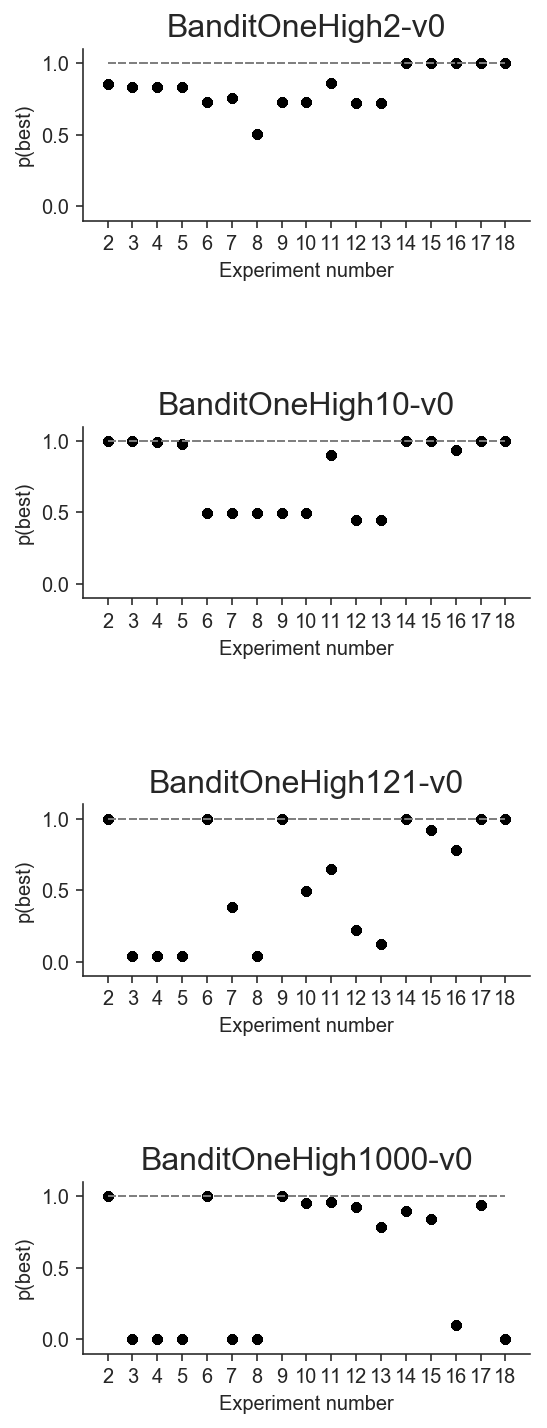

In [93]:
plot_sum_performance(env_names[0:4])

### Sparse

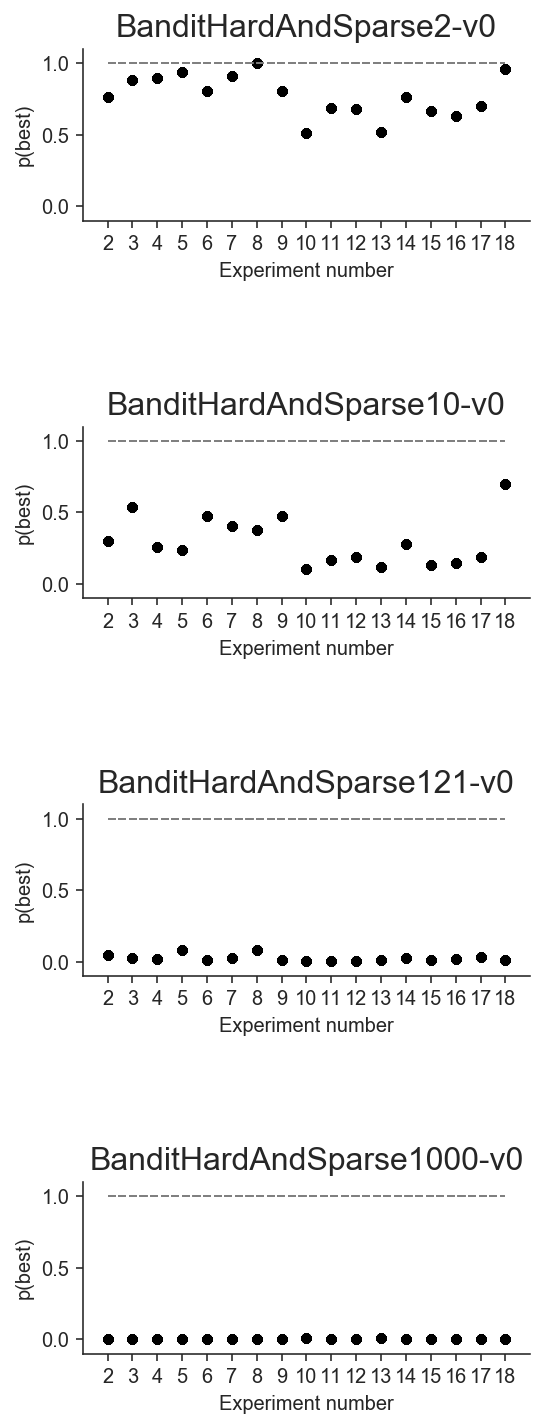

In [94]:
plot_sum_performance(env_names[4:8])

In [95]:
last_trials

-500